In [1]:
reset()

In [2]:
%run ntru-lattice-vfk-cvp.ipynb # code for the CVP on VFK lattices

In [3]:
%run auxiliary.ipynb

# Auxiliary functions

 We set, $\Phi_1(x)=x-1$ and  $\Phi_N(x) = D(x)/\Phi_1(x).$<br>
$N$ is prime, and $q\le 16N/3+16$ which is a power of two,
 $D(x)=x^N-1.$<br><br>
`GenKey(seed)`. Takes as input a *seed* and outputs a quadruple
`(pk,sk)`=$({\textbf h},({\textbf f},{\textbf f}_3,{\textbf h}_q)).$\
\
`1.` $(f(x),g(x))\xleftarrow{\$} {\mathcal{L}}_f\times {\mathcal{L}}_g$
\# `here we use the seed`\
`2.` $f_q(x)\leftarrow f^{-1}(x)\mod{(q,\Phi_N(x))}$ \# $\Phi_N(x)=x^{N-1}+\cdots x+1$\
`3.` $f_3(x)\leftarrow f^{-1}(x)\mod{(3,\Phi_N(x))}$\
`4.` $h(x) \leftarrow 3g(x)*f_q(x)\mod{(q,D(x))}$  $\# D(x)=x^N-1$\
`5.` $h_q(x) \leftarrow h^{-1}(x)\mod{(q,\Phi_N(x))}$ \
`6.` ${\mathbb{S}} \xleftarrow{\$} \{0,1\}^{256}$ \
`7.` **return**
 $(pk,sk)=({\textbf h},({\textbf f},{\textbf f}_3,{\textbf h}_q,{\mathbb{S}}))$


We also need to define the sample sets.<br>
With ${\mathcal{T}}_a$ we denote the set of **ternary** polynomials of
${\mathcal{R}}={\mathbb{Z}}[z]/(x^a-1)$ with degree at most $a$ and
$\mathcal{T}_a(d_1,d_2)\subset {\mathcal{T}}_{a}$ consists from elements
of ${\mathcal{T}}_{a}$ with $d_1$ coefficients equal to $1$ and $d_2$
equal to $-1.$ Furthermore, with
${\mathcal{T}}_a(w), w\in{\mathbb{Z}}_{>0}$ we denote the ternary
polynomials which have $w$ non-zero coefficients. We also have four sample spaces,
${\mathcal{L}}_f, {\mathcal{L}}_g, {\mathcal{L}}_r,$ and ${\mathcal{L}}_m.$\
$-$ ${\mathcal{L}}_m={\mathcal{L}}_g=
{\mathcal{T}}_{N-2}\big(\frac{q}{16}-1,\frac{q}{16}-1\big),$\
$-$ ${\mathcal{L}}_f={\mathcal{L}}_r={\mathcal{T}}_{N-2}.$


# Key Generation/Encrypt/Decrypt

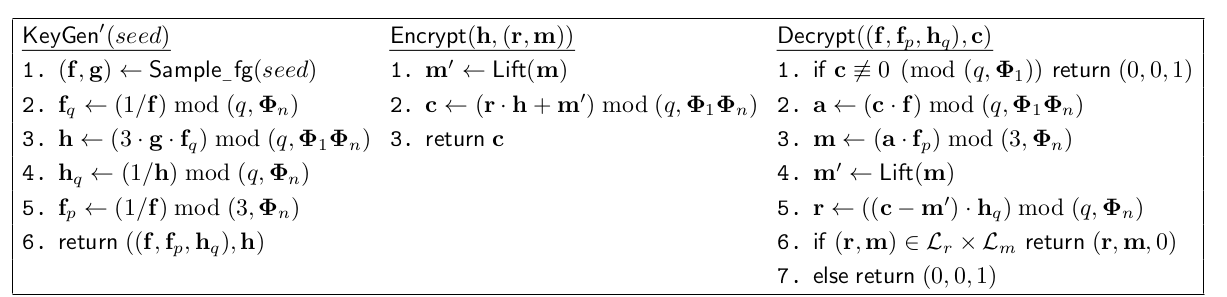

In [4]:
from fpylll import IntegerMatrix,LLL,GSO
import random
import numpy as np

In [5]:
def bits(N):
    if N==0:
        return 0
    else:
        return floor(log(N,2))+1

def pad_binary(bin_str):
    return '0' * (11 - len(bin_str)) + bin_str    

def count_equal(L1,L2):
    return sum(x == y for x, y in zip(L1, L2))

def correction_of_msg(N,m):
    '''
    N: the parameter of NTRU
    m: the message polynomial
    Output: a list of length N with the coefficients of m(x)
    '''
    m_list=m.list()
    if len(m_list)<N:
        diff = N - len(m_list)
        m_list.append(diff*[0])
    return flatten(m_list)

def random32(): return randrange(-2^31,2^31)        # a random integer in -2^31 and 2^31

def randomrange3():  
    ''' 
    generate a random integer in {0, 1, 2} 
    by utilizing a 32-bit random number generator : random32()
    '''
    return ((random32() & 0x3fffffff) * 3) >> 30


# we generate ternary polynomials of degre at most with d1 one and d2 minus one
def T(d1,d2,N):
    import random
    Zx.<x> = ZZ[]    
    a = d1*[1]
    b = d2*[-1]
    c = (N+2-d1-d2)*[0] #the length must be N+1 to get a polynomial of degree at most N
    L = flatten([a,b,c])
    random.shuffle(L) 
    return L,Zx(L)
    
def CenterLift(f,q,N):    
    f_balanced = list(   ((f[i]+q//2)%q) -q//2  for i in range(N)   )
    return Zx(f_balanced)

def reduce_mod_PhiN_and_modq(f):
    return Zx(S(f).lift())%q

def reduce_mod_DN_and_modq(f): # if f=G*F then we get the multiplication of G and F in R/(q,x^N-1) 
    return Zx(R(f).lift())%q

def Convolution_in_S_q(f,g,N,q): 
    PhiN=sum(x^i for i in [0..N-1])
    h = (f*g)%(PhiN)
    return  Zx(h)%q  

def Convolution_in_S(f,g,N):
    PhiN=sum(x^i for i in [0..N-1])
    h = (f*g)%(PhiN)
    #h1 = list( (h[i]%q)   for i in range(N) )
    return  Zx(h) 

def Invertmodprime_and_phiN(f,p,N):        #p must be prime
    phiN = sum(x^i for i in [0..N-1])
    if is_prime(p)==False:
        return "error"
    T = Zx.change_ring(Integers(p)).quotient(PhiN)
    return Zx(lift(1/T(f)))

def invert_mod_2_and_phiN(f):
    return Zx( (1/S2(f)).lift())

def Invertmodpowerofprime_mod_PhiN(f,Q,e,N): # Q prime, e: exponent
    F = invert_mod_2_and_phiN(f)
    if e == 1:      
        return F
    temp_exponent = 2
    while e>0:
        temp = Convolution_in_S(F,f,N)
        F = Convolution_in_S_q(F,2-temp,N,Q^temp_exponent)
        e = floor(e/2)
        temp_exponent = 2*temp_exponent
    return F

def Invert_mod3_and_PhiN(f):
    T = 1/S3(f)
    return T    

def private_keys(N):
    # for L_g we choose d=q/16-1
    # for L_f we choose T_{N-2}
    while True:
        f = Zx([randomrange3()-1 for i in range(N-1)])
        if S3(f).is_unit(): break
    d=q/16-1;g = T(d,d,N-2)
    return f,g[1]

def gen_keys(N,q): 
    f,g=private_keys(N);
    base_of_q = 2
    exponent  = int(log(q,2))
    # N is prime
    # We have set : q = (base_of_q)^(exponent)
    
    try:
        fq=Invertmodpowerofprime_mod_PhiN(f,base_of_q,exponent,N)
    except ZeroDivisionError:
        print("Oops! there is not inverse of f in S_{0}".format(q))
        return _,_,_,_,_,_
    try:
        f3 = Invert_mod3_and_PhiN(f)
    except ZeroDivisionError:
        print("Oops! there is not inverse of f in S_{0}".format(3))
        return _,_,_,_,_,_
    fq = fq%q
    h   = 3*reduce_mod_DN_and_modq(fq * g); # public key, we work mod<q,x^N-1>
    try: 
        hq=Invertmodpowerofprime_mod_PhiN(h,base_of_q,exponent,N)
    except ZeroDivisionError:
        print("Oops! there is not inverse of h in S_{0}".format(q))
        return
    hq = hq%q
    return h,f,Zx(f3.lift()),hq,g,fq

### Encryption
def enc(N,q,msg,h):
    r = Zx([randomrange3()-1 for i in range(N-1)]) #ephemeral key, a ternary of degree <=N-2
    ct1=reduce_mod_DN_and_modq(h*r)  # mod <q,x^N-1>
    ct = reduce_mod_DN_and_modq(ct1 + msg)   # mod <q,x^N-1>
    #print("r={0}\nct1={1}\nmsg={2}\nct={3}".format(r,ct1,msg,ct))
    return ct,r

### decryption
def decryption(ct,f,m):
    a=reduce_mod_DN_and_modq(ct * f)
    a=CenterLift(a,q,N)
    if S3(a*f3)==S3(m):
        print("decryption OK")
    return Zx(S3(a*f3).lift())


##  choose the hps variant you want

In [6]:
# parameters for NTRU-HPS 
# returns N and q
def ntruhps(x):
    if x==1:
        return 509,2048 #ntruhps2048509
    if x==2:
        return 677,2048
    if x==3:
        return 821,4096
N,q=ntruhps(3)

In [7]:
print("N,q=",N,q)
print(q/8 - 1<=2*N/3)
D,PhiN=x^N-1,sum(x^i for i in [0..N-1])

Zx.<x> = ZZ[]
R.<xN> = Zx.quotient(D)
S.<XN> = Zx.quotient(PhiN)

F3 = GF(3); 
F3x.<x3> = F3[]; 
Phi3N = sum(x3^i for i in [0..N-1])
S3.<X3> = F3x.quotient(Phi3N)

F2 = GF(2); F2x.<x2> = F2[]
Phi2N=sum(x2^i for i in [0..N-1])
S2.<X2> = F2x.quotient(Phi2N)


N,q= 821 4096
True


# The Attack<br>
The first step is to define the matrix 
$$ 
	M_k=
    \left[\begin{array}{c|c}
	I_N & -kI_N  \\
	\hline
	{\textbf 0}_N & qI_N   \\
	\end{array}\right].
    $$
    
Note that $b(x)=kc(x)$ so $b_i=kc_i.$<br>
We know  that $${\bf u}=(u_1,...,u_n)\in\{k-b_i , - b_i  , - k -b_i\}^N.$$
We have the ciphertext $c(x)$ and the public key $h(x).$ The encryption equation is $c(x)=r(x)*h(x)+m(x).$ Multiplying both sides with the integer $-k$ (for some positive $k$) we get 
$$
km(x)=b(x)+u(x),\text{ where } u(x)=-kr(x)*h(x) \text{ and } b(x)=k c(x) \ \text{in}\ {\mathcal{R}}/q.
$$
Therefore,  the previous equation in ${\mathcal{R}}$ is written
$$km(x)=b(x)+u(x)+qv(x),\text{ for some } v(x)\in {\mathcal{R}}.$$
In this equation, polynomials $m(x), u(x)$ are unknown.
We first remark that $b(x)+u(x)$ has its coefficients in $\{-k,0,k\}$. This is evident since $m(x)$ is ternary polynomial. So, the unknown polynomial $u(x)$ has the coefficient of $x^{i}$ in $\{k-b_i,-b_i,-k-b_i\},$ where $b_i$ are the coefficients of $b(x).$ 
 Say that $q=2048$<br> 
 **The new attack**<br>
 We assume that:<br>
 (1) we know the binary length of the entries $(u_i)$ of ${\bf u}.$ Since ${\bf u}\in {\mathbb{Z}}_q^N$ the binary length of each $u_i$ is at most $bits(q)-1=11$, since $q=2^{11}.$ <br>
 (2) We know the MSB and LSB of $u_i$.<br>
 Then we can have a succesfull attack for ntruhps2048509, ntruhps2048677.<br>

In [8]:
# construct M_k
# ************* #
def Mk(N,q,k):
    I=identity_matrix(N)
    Zero_Matrix=matrix(N)
    H=-k*I
    B_1=block_matrix([[I,H]])       
    B_2=block_matrix([[Zero_Matrix,q*I]])
    M_NTRU=block_matrix([[B_1],[B_2]])
    return M_NTRU

def u_vector(h,r,kappa):
    # u : the unknown vector such that u(x)=-kappa(h(x)*r(x)) mod q
    u_list = [ x%q for x in R(-kappa*r*h).list()]
    u_vector = vector(u_list)     # write u as sage vector
    return u_vector

def betta(kappa,ct,N):
    b      = kappa*ct % q
    Blist  = b.coefficients(sparse=False)
    return Blist



In [9]:
def decryption(ct,f,f3,m):
    a=reduce_mod_DN_and_modq(ct * f)
    a=CenterLift(a,q,N)
    if S3(a*f3)==S3(m):
        print("decryption OK")
    return Zx(S3(a*f3).lift())


In [ ]:
def gen_msg(q,N):
    msg = T(q/16-1,q/16-1,N-2)
    m = msg[1]
    while m.degree()==N-1:
        msg = T(q/16-1,q/16-1,N-2)
        m = msg[1]
    return msg


In [10]:
def generate_instance(N,q):
    h,f,f3,hq,g,fq = gen_keys(N=N,q=q)
    
    Zx.<x> = ZZ[]

    D=x^N-1
    PhiN = sum(x^i for i in [0..N-1])\
    
    R.<xN> = Zx.quotient(D)
    S.<XN> = Zx.quotient(PhiN)

    F3 = GF(3); 
    F3x.<x3> = F3[]; 
    Phi3N = sum(x3^i for i in [0..N-1])
    S3.<X3> = F3x.quotient(Phi3N)

    F2 = GF(2); F2x.<x2> = F2[]
    Phi2N=sum(x2^i for i in [0..N-1])
    S2.<X2> = F2x.quotient(Phi2N)

    M = []
    h,f,f3,hq,g,fq = gen_keys(N=N,q=q)
    msg = gen_msg(q,N) # Since we want messages of weight q/8-2.
    ct,r=enc(N,q,msg[1],h)     # the ciphertext and the ephemeral key
    m = msg[1]                 # the message as polynomial           
    _=decryption(ct,f,f3,m)    # we check if the decryption is correct
    return f,h,r,ct,msg

# print("N=",N)
# print("k=",kappa)
f,h,r,ct,msg=generate_instance(N,q)


decryption OK


We start we the VFK-CVK algorithm:

In [11]:
def init_attack(N,q,kappa):
    P = floor( kappa*q/(kappa^2 + 1) )
    M_k = Mk(N,q,kappa)
    M_NTRU_VFK=unimodular(P,N)*M_k
    # from paper: remark 5.1
    r = - ((kappa*P + kappa - q)*kappa + P + 1)
    s = (kappa*P + kappa - q)*(q - kappa*P ) - (P + 1)*P
    t = (kappa*P-q)*kappa + P
    diag1 = N * ( (1 + P )^2 + ( kappa*(P + 1) - q)^2 )
    diag2 = 1+kappa^2
    #print("r,s,t:",r,s,t)
    basis = M_NTRU_VFK.rows()
    super_basis=get_superbasis(basis)
    Q=get_qij(super_basis)
    #print("is VFK?",is_vfk(Q,N))
    return M_NTRU_VFK,super_basis,Q


We shall choose one of the oracles below. The first returns the MSB of $u_i$, the second the MSB and LSB
of $u_i$ and the third the two MSBs of $u_i$

In [12]:
def hypothesis_msb(A1_padded,A2_padded,A3_padded,u_padded,i):
    bits1 = A1_padded[i][0] 
    bits2 = A2_padded[i][0] 
    bits3 = A3_padded[i][0]       
    bitsu = u_padded[i][0] 
    return bits1,bits2,bits3,bitsu

def hypothesis_msb_lsb(A1_padded,A2_padded,A3_padded,u_padded,i):
    bits1 = A1_padded[i][0] + A1_padded[i][-1:]
    bits2 = A2_padded[i][0] + A2_padded[i][-1:]
    bits3 = A3_padded[i][0] + A3_padded[i][-1:]       
    bitsu = u_padded[i][0] + u_padded[i][-1:]
    return bits1,bits2,bits3,bitsu


def hypothesis_msb1_msb2(A1_padded,A2_padded,A3_padded,u_padded,i):
    bits1 = A1_padded[i][0] + A1_padded[i][1]
    bits2 = A2_padded[i][0] + A2_padded[i][1]
    bits3 = A3_padded[i][0] + A3_padded[i][1]       
    bitsu = u_padded[i][0] + u_padded[i][1]
    return bits1,bits2,bits3,bitsu

In [14]:
def compute_I2(E,I):
    '''
    this function returns I (which is I1) and range(N)-I, which is I2
    '''
    I1=[]
    I2=[]
    for i in range(len(E)):
        if i in I:
            I1.append(i)
        else:
            I2.append(i)
    return I1,I2


def first_step(kappa,h,r,ct,N):
    '''
    In first and second step we construc the vector E, we shall use to build out target vector.
    In this step we shall set E_i = u_i for all i in I_1. In this step we also 
    compute I1, i.e. the indices i, where u_i is exactly computed. 
    '''
    I1=[]
    M_k = Mk(N,q,kappa)
    u = u_vector(h,r,kappa)    
    Blist = betta(kappa,ct,N)
    # below we encode our hypothesis, e.g. we know the MSB and LSB of u_i
        
    A1 = [bin( (-x)%q)[2:] for x in Blist]
    A2 = [bin( (-x+kappa)%q)[2:] for x in Blist]
    A3 = [bin( (-x-kappa)%q)[2:] for x in Blist]
    u_bin = [bin(x)[2:] for x in list(u)]
    A1_padded = [pad_binary(x) for x in A1]
    A2_padded = [pad_binary(x) for x in A2]
    A3_padded = [pad_binary(x) for x in A3]
    u_padded  = [pad_binary(x) for x in u_bin]

    E = [0] * len(u) # len(u) = N
    for i in range(len(A1_padded)): 
        # this is the oracle that outputs some bits of u
        bits1,bits2,bits3,bitsu=hypothesis_msb_lsb(A1_padded,A2_padded,A3_padded,u_padded,i)
        
    # Check if bits1 equals u
        if bits1 == bitsu:
            if bits2 != bits1 and bits3 != bits1:
                E[i] = u[i]
                I1.append(i)
        # Check if bits2 equals u
        if bits2 == bitsu:
            if bits1 != bits2 and bits3 != bits2:
                E[i] = u[i]
                I1.append(i)
        # Check if bits3 equals u
        if bits3 == bitsu:
            if bits1 != bits3 and bits2 != bits3:
                E[i] = u[i]
                I1.append(i)
        #print(f"{i:<6}{A1_padded[i]:<20}{A2_padded[i]:<20}{A3_padded[i]:<20}{u_padded[i]:<20}")
    return I1,E,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded

In [15]:
def second_step(I,kappa,temp_E0,N,A1_padded,A2_padded,A3_padded,u_padded):
    import copy
    E = copy.copy(temp_E0)
    S = [0] * N
    I1,I2=compute_I2(temp_E0,I)
    for i in I2:
        if i in I2:
            # this is the oracle that outputs some bits of u
            bits1,bits2,bits3,bitsu=hypothesis_msb_lsb(A1_padded,A2_padded,A3_padded,u_padded,i)
            
            if bitsu==bits1 and bitsu==bits2:
                S[i]=int( ( int(A1_padded[i],2) + int(A2_padded[i],2) )/2 )
                continue
            if bitsu==bits2 and bitsu==bits3:
                S[i]=int( ( int(A2_padded[i],2) + int(A3_padded[i],2) )/2 )
                continue            
            if bitsu==bits3 and bitsu==bits1:
                S[i]=int( ( int(A3_padded[i],2) + int(A1_padded[i],2) )/2 )  

    for i in I2:
        E[i]=S[i] # for u_i, i\in I_2, we do not have the exact value of u_i, as in the in the case i\in I_1
    return E,S


In [16]:
def final_step_babai(kappa,guessing_msg,E0,Blist,M_k):
    E_ = [0]*N + list(E0)
    if len(Blist)==N:
        target = vector(guessing_msg + Blist) + vector(E_)
    Mk_fplll = IntegerMatrix.from_matrix(M_k)
    M_GSO = GSO.Mat(Mk_fplll)
    M_GSO.update_gso()
    L_babai = M_GSO.babai(target) # we call Babai from fpylll library
    w_babai = sum(-L_babai[i]*M_k[i] for i in range(Mk_fplll.nrows)).list() # the output
    return w_babai[0:N]


def final_step_vfk(kappa,guessing_msg,E0,N,Blist):  
    M_NTRU_VFK,superbasis,Q=init_attack(N,q,kappa)
    E_ = [0]*N + list(E0)
    if len(Blist)==N:
        target = vector(guessing_msg + Blist) + vector(E_)
    basis = M_NTRU_VFK.rows()
    L_vfk=cvp_vfk(N,Q,basis,superbasis,target)
    w_vfk =[-x for x in L_vfk]
    return w_vfk[0:N]


# we set the list of k's

In [20]:
# for 1 MSB and 1 LSB #

# for q=2048
kappa_list_1_2048 =[201, 63, 171, 53, 131, 45, 97, 41, 95,87,\
                     85, -36, 83, 81, 79, 77, 75, 443, 453, 470, 489, \
                     555, 560, 571, 600, 607]

# for q=4096
kappa_list_1_4096 = [201, 63, 171, 53, 131, 45, 97, 41, 95,87,\
                     85, -36, 83, 81, 79, 77, 75, 443, 453, 470, 489, 495, \
                     555, 560, 571, 589, 600, 607]

# for 1 MSB #

# for q=2048
kappa_list_2048_1MSB = [201,63, 171, 55, 131, 51, 97, 47, 95, 44, 87, 41,\
              85, 39, 83, 37, 81, 79, 31, 77, 75, -36, 443, 454, -42, 555, \
              457, 481, 493, 497, 501, 509, 519, 523, 538, 551, 568, 578, \
              584, 598, 601, 605, 607, 611, 615, 619, 624, 631, 639, 643, \
              649, 655, 661, 679, 681, 685, 700, 704]

kappa_list = kappa_list_1_4096

In [21]:
def the_attack(count,kappa_list,q,N):
    if N==509:
        print("ntruhps2048509")
    if N==677:
        print("ntruhps2048677")
    if N==821:
        print("ntruhps4096821")
        
    import time
    tr = 0
    for j in range(count):
        print("-----",j+1,"------")
        # we generate new parameters
        f,h,r,ct,msg=generate_instance(N,q)
        # set up the timer
        start = time.time()
        p=0
        for x in kappa_list:
            if x<64:
                p=p+1
        print(" <64 :",p,"\n",">64 :",len(kappa_list)-p)
        I_11=[];I_12=[]
        kappa=kappa_list[0]
        print("kappa:",kappa)
        I1,temp_E0,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa,h,r,ct,N)
        I_11,I_12=compute_I2(temp_E0,I1)
        E0,S0 = second_step(I_11,kappa,temp_E0,N,A1_padded,A2_padded,A3_padded,u_padded)
        # the first k is >64, so we choose Babai
        w0=final_step_babai(kappa,[0]*N,E0,Blist,M_k)
        T=0
        for i in range(N):
            if (w0[i])==(msg[0][i]):
                T=T+1
        print("overall elements found in the first round (this number it may be larger than 'new bits found'):",T)
        print("overall elements found in the first round (under estimation'):",len(I_11))
        print("------------")
        if msg[0]==w0:
            print("true")
            kappa_list=[]
        for i in range(1,len(kappa_list)):
            I_21=[];I_22=[]
            kappa=kappa_list[i]
            print("round:",i+1)
            print("kappa:",kappa)
            I1,temp_E,M_k,u,Blist,A1_padded,A2_padded,A3_padded,u_padded = first_step(kappa,h,r,ct,N)
            I_21,I_22=compute_I2(temp_E,I1)
            E,S = second_step(I_21,kappa,temp_E,N,A1_padded,A2_padded,A3_padded,u_padded)
            
            # choose Babai or CVP_VFK
            if abs(kappa)>64:
                w1=final_step_babai(kappa,w0,E,Blist,M_k)
            else:
                w1=final_step_vfk(kappa,w0,E,N,Blist)
                
            lst=[x for x in I_21 if x not in I_11]
            print("new elements found:",len(lst))
            # update w0
            # we update only elements in {-1,0,1}
            for x in lst:
                if w1[x] in [-1,0,1]:
                    w0[x]=w1[x]

            # update I_11
            I_11 = (list(set(I_11+I_21))) # these are the indices where we know the exact values of u_i

            TT=0
            for i in range(N):
                if (w0[i])==(msg[0][i]):
                    TT=TT+1
            print("overall elements found (compared with real message):",TT)
            print("overall elements found (under estimation):",len(I_11))
            print("--------------")
            if msg[0]==w0:
                print("true")
                tr = tr + 1
                break
        print(time.time()-start)
    print("N,q:",N,q)
    print("hypothesis: the msb of u[i]")
    print("succeses,count",tr,count)
the_attack(10,kappa_list,q,N)   

ntruhps4096821
----- 1 ------
decryption OK
 <64 : 5 
 >64 : 23
kappa: 201
overall elements found in the first round (this number it may be larger than 'new bits found'): 396
overall elements found in the first round (under estimation'): 396
------------
round: 2
kappa: 63
new elements found: 23
overall elements found (compared with real message): 419
overall elements found (under estimation): 419
--------------
round: 3
kappa: 171
new elements found: 63
overall elements found (compared with real message): 482
overall elements found (under estimation): 482
--------------
round: 4
kappa: 53
new elements found: 22
overall elements found (compared with real message): 504
overall elements found (under estimation): 504
--------------
round: 5
kappa: 131
new elements found: 40
overall elements found (compared with real message): 544
overall elements found (under estimation): 544
--------------
round: 6
kappa: 45
new elements found: 16
overall elements found (compared with real message): 560
